<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/2020_11_23_refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Colab env


In [1]:

import sklearn
sklearn.__version__
#!pip uninstall scikit-learn -y
#!pip install scikit-learn
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [2]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [3]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
# peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# peek at modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27  2020 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27  2020 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27  2020 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27  2020 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27  2020 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27  2020 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27  2020 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27  2020 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27  2020 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27  2020 9_soul-groove9_105_beat_4-4.mid
total 52
-rw------- 1 root root 28586 Aug 18 21:35 data_prep.py
-rw------- 1 root root  2904 Nov 18 21:57 pipeline_utils.py
drwx------ 2 root root  4096 May 10  2020 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root 

## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [5]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [6]:
# regular imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

# object that provides colours for charts
from itertools import cycle

# sklearn imports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
# install required libs
!pip install mido

     |████████████████████████████████| 61kB 3.1MB/s 


In [8]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp
import pipeline_utils as pu
import stats_n_features as sf

>> LOADING custom module, when: 2020-11-24 13:32:25.454444, module name: stats_n_features
>> LOADING custom module, when: 2020-11-24 13:32:25.455536, module name: data_prep
>> LOADING custom module, when: 2020-11-24 13:32:25.702439, module name: pipeline_utils


In [9]:
# test module function calls..
dp.test_function_call('bling')
sf.test_function_call('hello')

Test function in data_prep.py called and worked! when: 2020-11-24 13:32:25.735726,  param:bling
Test function in stats_n_features called and worked! when: 2020-11-24 13:32:25.735927,  param:hello


## Pandas display options

In [10]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load & filter data...

In [11]:
##################################
######## LOAD

my_data = dp.load_all_data()
all_drummer_data = my_data.copy()
;

BULK LOAD: drummer1, drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1300 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'MIDI' 1300 messages>]
    MIDI file type: 0
    > processing track: <midi track 'MIDI' 1300 messages>
    __notes pre-filter: [36. 37. 38. 40. 43. 44. 51. 52. 53. 55.]
    __applying filter: [44]
    __notes post filter: [36. 37. 38. 40. 43. 51. 52. 53. 55.]
    note_on span - first tick: 3 , last tick: 30658 
    good instruments: 5, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 43.0: 'High Floor

''

## Single file tests..

In [12]:
##################################
######## EXPLORE SINGLE FILE

# experimenting on a single file here ...
key1 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid'
#key2 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'

test_data = all_drummer_data[key1]
df1 = test_data.tight_df.copy()
df1.head()

print('stats for: {}'.format(key1))
df1['beat_offset'].groupby(df1['note']).describe()
df1['velocity'].groupby(df1['note']).describe()


note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                  hh        55            7                1
           1                kick        64           10                1
           3                kick        57          -29                3
           3                  hh        31           -2                3
           5                  hh        54          -13                5

stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.0,27.0
kick,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.0,10.0
snare,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.5,55.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,50.436508,9.891003,30.0,44.0,49.0,56.00,83.0
kick,54.0,60.796296,15.543463,42.0,52.0,59.5,63.75,127.0
snare,79.0,71.506329,35.822523,8.0,33.0,90.0,102.00,117.0


In [13]:
# pull out notes in named bars...
display(df1.xs(1, level='bar_number')) 
display(df1.xs(2, level='bar_number')) 

,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,55,7,1
1,kick,64,10,1
3,kick,57,-29,3
3,hh,31,-2,3
5,hh,54,-13,5
5,snare,93,-5,5
7,hh,42,-16,7
8,snare,33,-12,8
10,snare,33,-14,10


,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,42,-7,1
1,kick,55,-5,1
3,kick,62,-10,3
3,hh,41,3,3
5,snare,94,4,5
5,hh,51,5,5
7,hh,45,7,7
8,snare,32,7,8
9,hh,43,2,9


## Filter songs...

In [14]:

# FILTER SONGS BEING TESTED, ADD LABEL

def addLabelCol(df, label):
  '''
  Takes as input data_prep.PerformanceData.tight_df

  Returns df with additional colum for Y/ label called 'drummer_ID'
  '''

  # df['drummer_ID'] = label
  df.insert(0, 'drummer_ID', label) # add it as first col

  return df


# specify style being processed
# 1_funk-groove1
# 3_soul-groove3
# 4_soul-groove4
# 6_hiphop-groove6
# 8_rock-groove8

#style_filter = "1_funk-groove1"  
style_filter = "3_soul-groove3"
#style_filter = "4_soul-groove4"
#style_filter = "6_hiphop-groove6"
#style_filter = "8_rock-groove8"

songs_data = []


# iterate through loaded files, extract songs
# matching the style set in 'style_filter', then
# add the label/ Y col ..
for next_file in all_drummer_data.keys():
  perf_data = all_drummer_data[next_file]
  file_name = perf_data.file_wrapper.my_file_name
  if style_filter in file_name:
    print('Working on: {}'.format(file_name))
    df1 = perf_data.tight_df.copy()
    df2 = addLabelCol(df1, perf_data.drummer_id)  
    df2.reset_index(drop=True, inplace=True)
    songs_data.append(df2)
  else:
    #print('  ... ignoring: {}'.format(file_name))
    pass

# merge all into single df, drop indexes, reset default index
all_data = pd.concat(songs_data)
all_data.reset_index(inplace=True, drop=True)

# .. at this point, df 'all_data' is a collection
# of data for the same song, across all drummers, with
# DrummerID label

all_data.head(10)


Working on: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid
Working on: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid
Working on: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer7/eval_session/3_soul-groove3_86_beat_4-4.mid
Working on: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer8/eval_session/3_soul-groove3_86_beat_4-4.mid


,drummer_ID,note,velocity,beat_offset,bar_beat_number
0,drummer1,hh,32,0,1
1,drummer1,kick,60,0,1
2,drummer1,snare,15,1,1
3,drummer1,hh,18,0,2
4,drummer1,hh,60,3,3
5,drummer1,hh,24,3,4
6,drummer1,kick,52,4,4
7,drummer1,snare,102,9,5
8,drummer1,hh,46,9,5
9,drummer1,hh,28,-2,6


In [15]:
#all_data[:10]
#all_data[5:8]
#all_data.iloc[0:2, :0]
all_data.shape


(1677, 5)

# Setup pipelines

## X, y split

Break into X, y before continuing ...

In [16]:
# BREAK INTO X, y
y = all_data['drummer_ID'].to_numpy()
X = all_data.drop(['drummer_ID' ], axis=1) #.to_numpy()

In [17]:
X.head(10)

,note,velocity,beat_offset,bar_beat_number
0,hh,32,0,1
1,kick,60,0,1
2,snare,15,1,1
3,hh,18,0,2
4,hh,60,3,3
5,hh,24,3,4
6,kick,52,4,4
7,snare,102,9,5
8,hh,46,9,5
9,hh,28,-2,6


## Create transformers

In [18]:

t_one_hot = OneHotEncoder(drop='first')     # instrument, beat_pos
t_scaler_robust = RobustScaler(quantile_range=(25, 75))  # velocity & offset
t_scaler_mm_1 = MinMaxScaler(feature_range=(0, 1))       # velocity
t_scaler_mm_2 = MinMaxScaler(feature_range=(-0.5, 0.5))  # offset

# col indexes, 0-3: note, velocity, beat_offset, bar_beat_number

# robust scaling of vel & offset, one hot for instrument  
t_v0_robust = [('t_scaler_robust', t_scaler_robust, [1, 2]), ('t_one_hot', t_one_hot, [0])]
ct_v0 = ColumnTransformer(transformers=t_v0_robust, remainder='passthrough', sparse_threshold=0)
 

# this should be equivalent to previous pipeline for KNN
# MinMax scaling of vel & offset, one hot for note
t_v1_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1]), # velocity 
               ('t_scaler_mm_2', t_scaler_mm_2, [2]),  # offset
               ('t_one_hot', t_one_hot, [0, 3])]  # instrument, beat_pos
ct_v1 = ColumnTransformer(transformers=t_v1_mm, remainder='passthrough', sparse_threshold=0)

# this should be equivalent to previous pipeline for KNN
# MinMax scaling of vel & offset, one hot for note
t_v2_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1]), # velocity 
               ('t_scaler_mm_2', t_scaler_mm_2, [2]),  # offset
               ('t_one_hot', t_one_hot, [0])]  # instrument
ct_v2 = ColumnTransformer(transformers=t_v2_mm, remainder='passthrough', sparse_threshold=0)


# MinMax scaling of vel & offset, one hot for note
t_v3_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1, 2]), ('t_one_hot', t_one_hot, [0])]
ct_v3 = ColumnTransformer(transformers=t_v3_mm, remainder='passthrough', sparse_threshold=0)


In [19]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context


In [20]:
ct_v0
ct_v1
ct_v2
ct_v3

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_robust',
                                 RobustScaler(quantile_range=(25, 75)),
                                 [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0, 3])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

## Sanity checking ..


Try a transformer, peek at the outputs...

In [21]:
output1 = ct_v1.fit_transform(X)
output2 = ct_v2.fit_transform(X)
output3 = ct_v3.fit_transform(X)

In [22]:
output1.shape
pd.DataFrame(output1).head()

(1677, 19)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.221311,0.004202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.450820,0.004202,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.081967,0.012605,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.106557,0.004202,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.450820,0.029412,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
output2.shape
pd.DataFrame(output2).head()


(1677, 5)

,0,1,2,3,4
0,0.221311,0.004202,0.0,0.0,1.0
1,0.450820,0.004202,1.0,0.0,1.0
2,0.081967,0.012605,0.0,1.0,1.0
3,0.106557,0.004202,0.0,0.0,2.0
4,0.450820,0.029412,0.0,0.0,3.0


In [24]:
output3.shape
pd.DataFrame(output3).head()

(1677, 5)

,0,1,2,3,4
0,0.221311,0.504202,0.0,0.0,1.0
1,0.450820,0.504202,1.0,0.0,1.0
2,0.081967,0.512605,0.0,1.0,1.0
3,0.106557,0.504202,0.0,0.0,2.0
4,0.450820,0.529412,0.0,0.0,3.0


## Train/ test split...

In [25]:
# TEST/ TRAIN SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)


In [26]:
X_train.head(3)

,note,velocity,beat_offset,bar_beat_number
1295,snare,113,12,13
179,hh,43,-6,5
559,hh,23,-12,6


## Some pipelines

In [27]:
# setup our pre-processing and modelling pipeline
pipe_v0 = Pipeline(steps=[('prep',ct_v0), ('knn', KNeighborsClassifier(7))])
pipe_v1 = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
pipe_v2 = Pipeline(steps=[('prep',ct_v2), ('knn', KNeighborsClassifier(7))])
pipe_v3 = Pipeline(steps=[('prep',ct_v3), ('knn', KNeighborsClassifier(7))])


# Test pipelines

## Util functions


In [28]:

def KNN_predict(X_train, y_train, X_test, n=5):
  # Fit model, do predictions

  KNN_model = KNeighborsClassifier(n)
  display(KNN_model)
  KNN_model.fit(X_train, y_train)
  return KNN_model.predict(X_test)

def KNN_results(pred, test, labels):
  # evaluate results

  print('\nKNN Accuracy score...')
  print('  KNN: {}'.format(accuracy_score(pred, test)))

  print('\nKNN classification report...')
  print(classification_report(pred, test))

def c_matrix(pred, test, labels):
  # plot results

  print('\nConfusion matrix...')
  matrix2 = confusion_matrix(pred, test)
  m_df = pd.DataFrame(matrix2, index=labels, columns=labels)
  _ = plt.figure(figsize=(6, 6))
  sns.heatmap(m_df, annot=True, cbar=None, cmap="Reds")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()



## Manual fit model, do predictions

Testing single model by hand

In [31]:
print('fitting the pipeline ...')
pipe_v3.fit(X_train, y_train)

print('predicting ...')
predictions_1 = pipe_v3.predict(X_test)

fitting the pipeline ...


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

predicting ...


## Evaluate model results


KNN Accuracy score...
  KNN: 0.6994047619047619

KNN classification report...
              precision    recall  f1-score   support

    drummer1       0.76      0.66      0.70       108
    drummer5       0.70      0.64      0.67        91
    drummer7       0.52      0.78      0.62        59
    drummer8       0.86      0.77      0.81        78

    accuracy                           0.70       336
   macro avg       0.71      0.71      0.70       336
weighted avg       0.72      0.70      0.70       336


Confusion matrix...


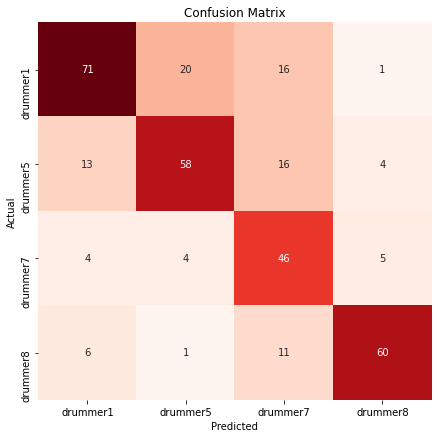

In [32]:
# y = list of all y values from dataset
classes = np.unique(y)
KNN_results(predictions_1, y_test, classes)
c_matrix(predictions_1, y_test, classes)

# K-fold CV

In [33]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline

# list of ColumnTransformers setup earlier ..
cts = [ct_v0, ct_v1, ct_v2, ct_v3]


results = []
best_score = 0
best_info = ''

kf = KFold(n_splits=10, shuffle=True, random_state=27)

for idx, ct in enumerate(cts):
  print("\n_______________________________________________________")
  print("\n>>>> pipe #{}.. \n".format(idx))
  
  # Calculating error for K values between 1 and 20
  for next_k in range(1, 20):
    next_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier(next_k))])
    cv_results = cross_val_score(next_pipe, X, y, cv=kf, scoring="accuracy", n_jobs=-1 )
    results.append(cv_results)

    # print out put of this run.
    this_mean = cv_results.mean()
    this_run = "pipe #{}, k={}, mean:{}".format(idx, next_k, this_mean)
    print('\n\n ___ '+this_run)
    cv_results

    # check for best
    if this_mean > best_score:
      best_score = this_mean
      best_info = this_run
    
print("\n\nBest score was > {}".format(best_score))
print(best_info)




_______________________________________________________

>>>> pipe #0.. 



 ___ pipe #0, k=1, mean:0.6517821499857428


array([0.64880952, 0.67261905, 0.64285714, 0.63690476, 0.6547619 ,
       0.64880952, 0.61904762, 0.67664671, 0.67065868, 0.64670659])



 ___ pipe #0, k=2, mean:0.6314870259481037


array([0.61904762, 0.64285714, 0.60714286, 0.64285714, 0.6547619 ,
       0.63095238, 0.61904762, 0.66467066, 0.60479042, 0.62874251])



 ___ pipe #0, k=3, mean:0.6517714570858283


array([0.63690476, 0.70238095, 0.60714286, 0.625     , 0.67857143,
       0.63690476, 0.6547619 , 0.68263473, 0.68263473, 0.61077844])



 ___ pipe #0, k=4, mean:0.6386512688907899


array([0.64880952, 0.69047619, 0.56547619, 0.60119048, 0.63095238,
       0.64880952, 0.66666667, 0.65868263, 0.64670659, 0.62874251])



 ___ pipe #0, k=5, mean:0.6392750213858


array([0.60714286, 0.66071429, 0.55952381, 0.60119048, 0.66071429,
       0.67857143, 0.64285714, 0.68862275, 0.64071856, 0.65269461])



 ___ pipe #0, k=6, mean:0.6291132021670943


array([0.61904762, 0.66071429, 0.5297619 , 0.63095238, 0.63690476,
       0.64880952, 0.6547619 , 0.66467066, 0.61676647, 0.62874251])



 ___ pipe #0, k=7, mean:0.6279191616766469


array([0.61904762, 0.64285714, 0.54166667, 0.5952381 , 0.63095238,
       0.67857143, 0.66666667, 0.64071856, 0.64071856, 0.62275449])



 ___ pipe #0, k=8, mean:0.6296870544625035


array([0.61309524, 0.6547619 , 0.53571429, 0.6547619 , 0.625     ,
       0.66666667, 0.67261905, 0.65868263, 0.59281437, 0.62275449])



 ___ pipe #0, k=9, mean:0.6320929569432563


array([0.63690476, 0.64880952, 0.5297619 , 0.63690476, 0.61309524,
       0.66666667, 0.67261905, 0.65269461, 0.62275449, 0.64071856])



 ___ pipe #0, k=10, mean:0.63267750213858


array([0.64880952, 0.66666667, 0.55952381, 0.625     , 0.60119048,
       0.63095238, 0.69642857, 0.67065868, 0.5988024 , 0.62874251])



 ___ pipe #0, k=11, mean:0.6249001996007983


array([0.66666667, 0.6547619 , 0.54166667, 0.625     , 0.61904762,
       0.6547619 , 0.6547619 , 0.62874251, 0.60479042, 0.5988024 ])



 ___ pipe #0, k=12, mean:0.61535500427716


array([0.64880952, 0.6547619 , 0.55357143, 0.61904762, 0.58333333,
       0.63095238, 0.66666667, 0.61077844, 0.58083832, 0.60479042])



 ___ pipe #0, k=13, mean:0.6117978329056173


array([0.66071429, 0.61904762, 0.5297619 , 0.63690476, 0.5952381 ,
       0.60119048, 0.6547619 , 0.64670659, 0.5748503 , 0.5988024 ])



 ___ pipe #0, k=14, mean:0.5945181066438552


array([0.64880952, 0.5952381 , 0.50595238, 0.61904762, 0.56547619,
       0.60119048, 0.61904762, 0.62874251, 0.58083832, 0.58083832])



 ___ pipe #0, k=15, mean:0.5927288280581694


array([0.64285714, 0.61904762, 0.52380952, 0.61309524, 0.54166667,
       0.5952381 , 0.60714286, 0.62874251, 0.56886228, 0.58682635])



 ___ pipe #0, k=16, mean:0.583176504134588


array([0.625     , 0.60714286, 0.54761905, 0.61309524, 0.51785714,
       0.58333333, 0.60119048, 0.5988024 , 0.58083832, 0.55688623])



 ___ pipe #0, k=17, mean:0.5748253493013973


array([0.56547619, 0.63690476, 0.51785714, 0.60119048, 0.54166667,
       0.58333333, 0.5952381 , 0.58682635, 0.55688623, 0.56287425])



 ___ pipe #0, k=18, mean:0.5527409466780724


array([0.58333333, 0.55357143, 0.5297619 , 0.58333333, 0.52380952,
       0.55952381, 0.58928571, 0.55688623, 0.52095808, 0.52694611])



 ___ pipe #0, k=19, mean:0.5545373538637012


array([0.57142857, 0.55952381, 0.53571429, 0.5952381 , 0.50595238,
       0.58333333, 0.57142857, 0.5748503 , 0.50898204, 0.53892216])


_______________________________________________________

>>>> pipe #1.. 



 ___ pipe #1, k=1, mean:0.6845309381237525


array([0.69047619, 0.71428571, 0.66071429, 0.69047619, 0.73809524,
       0.66071429, 0.67857143, 0.68263473, 0.69461078, 0.63473054])



 ___ pipe #1, k=2, mean:0.6696642429426861


array([0.63690476, 0.68452381, 0.60714286, 0.70238095, 0.70238095,
       0.67261905, 0.6547619 , 0.7245509 , 0.66467066, 0.64670659])



 ___ pipe #1, k=3, mean:0.6869617907043055


array([0.67261905, 0.73214286, 0.63690476, 0.69047619, 0.68452381,
       0.70833333, 0.64880952, 0.71856287, 0.71257485, 0.66467066])



 ___ pipe #1, k=4, mean:0.6941082121471343


array([0.67857143, 0.73809524, 0.66666667, 0.67857143, 0.70833333,
       0.69642857, 0.67261905, 0.73053892, 0.67664671, 0.69461078])



 ___ pipe #1, k=5, mean:0.7000534644995723


array([0.7202381 , 0.72619048, 0.64285714, 0.70238095, 0.72619048,
       0.7202381 , 0.67261905, 0.71257485, 0.70658683, 0.67065868])



 ___ pipe #1, k=6, mean:0.6893213572854291


array([0.69642857, 0.72619048, 0.625     , 0.68452381, 0.69642857,
       0.71428571, 0.69047619, 0.70658683, 0.68263473, 0.67065868])



 ___ pipe #1, k=7, mean:0.68634873110921


array([0.67857143, 0.7202381 , 0.64880952, 0.64880952, 0.70238095,
       0.71428571, 0.68452381, 0.7245509 , 0.68263473, 0.65868263])



 ___ pipe #1, k=8, mean:0.6839749073282008


array([0.70833333, 0.70238095, 0.61309524, 0.67261905, 0.68452381,
       0.67261905, 0.70833333, 0.7005988 , 0.65868263, 0.71856287])



 ___ pipe #1, k=9, mean:0.6875427715996578


array([0.71428571, 0.69047619, 0.625     , 0.69642857, 0.69047619,
       0.67857143, 0.70833333, 0.70658683, 0.65868263, 0.70658683])



 ___ pipe #1, k=10, mean:0.6839499572284004


array([0.70238095, 0.72619048, 0.60119048, 0.67857143, 0.70238095,
       0.67857143, 0.71428571, 0.71257485, 0.62874251, 0.69461078])



 ___ pipe #1, k=11, mean:0.6768213572854291


array([0.69642857, 0.68452381, 0.60714286, 0.69047619, 0.67261905,
       0.66071429, 0.69642857, 0.69461078, 0.67065868, 0.69461078])



 ___ pipe #1, k=12, mean:0.6702594810379241


array([0.67857143, 0.67261905, 0.60714286, 0.67857143, 0.67261905,
       0.67857143, 0.67857143, 0.69461078, 0.66467066, 0.67664671])



 ___ pipe #1, k=13, mean:0.6613202167094383


array([0.67857143, 0.64880952, 0.57738095, 0.68452381, 0.6547619 ,
       0.66666667, 0.68452381, 0.68263473, 0.65269461, 0.68263473])



 ___ pipe #1, k=14, mean:0.6571428571428571


array([0.68452381, 0.66071429, 0.60714286, 0.67857143, 0.64285714,
       0.64880952, 0.64880952, 0.69461078, 0.62275449, 0.68263473])



 ___ pipe #1, k=15, mean:0.6535429141716568


array([0.70238095, 0.6547619 , 0.57738095, 0.67857143, 0.64285714,
       0.67261905, 0.6547619 , 0.67065868, 0.62874251, 0.65269461])



 ___ pipe #1, k=16, mean:0.6475940975192472


array([0.6547619 , 0.66666667, 0.57738095, 0.67857143, 0.63690476,
       0.64285714, 0.66071429, 0.67065868, 0.62874251, 0.65868263])



 ___ pipe #1, k=17, mean:0.6440226689478188


array([0.67857143, 0.66666667, 0.57738095, 0.6547619 , 0.64880952,
       0.61904762, 0.63690476, 0.65269461, 0.64071856, 0.66467066])



 ___ pipe #1, k=18, mean:0.6356822070145423


array([0.66071429, 0.66071429, 0.56547619, 0.63095238, 0.64285714,
       0.60714286, 0.64285714, 0.67065868, 0.60479042, 0.67065868])



 ___ pipe #1, k=19, mean:0.6356893356144853


array([0.67261905, 0.6547619 , 0.55357143, 0.625     , 0.64285714,
       0.61904762, 0.63095238, 0.67664671, 0.61077844, 0.67065868])


_______________________________________________________

>>>> pipe #2.. 



 ___ pipe #2, k=1, mean:0.6881130595950955


array([0.69047619, 0.72619048, 0.6547619 , 0.70238095, 0.73809524,
       0.66666667, 0.67261905, 0.68263473, 0.7005988 , 0.64670659])



 ___ pipe #2, k=2, mean:0.6702594810379242


array([0.63690476, 0.69047619, 0.60714286, 0.70833333, 0.70238095,
       0.67261905, 0.64880952, 0.71856287, 0.67065868, 0.64670659])



 ___ pipe #2, k=3, mean:0.6863665526090676


array([0.67261905, 0.73214286, 0.63690476, 0.69047619, 0.68452381,
       0.70833333, 0.64285714, 0.71856287, 0.71257485, 0.66467066])



 ___ pipe #2, k=4, mean:0.6964927288280581


array([0.67857143, 0.74404762, 0.66666667, 0.67261905, 0.71428571,
       0.70833333, 0.67261905, 0.73053892, 0.67664671, 0.7005988 ])



 ___ pipe #2, k=5, mean:0.70124750499002


array([0.7202381 , 0.72619048, 0.64880952, 0.70238095, 0.72619048,
       0.7202381 , 0.67261905, 0.71257485, 0.70658683, 0.67664671])



 ___ pipe #2, k=6, mean:0.6893249215854006


array([0.69642857, 0.73214286, 0.625     , 0.68452381, 0.69047619,
       0.71428571, 0.68452381, 0.70658683, 0.68263473, 0.67664671])



 ___ pipe #2, k=7, mean:0.6869475335044196


array([0.67857143, 0.7202381 , 0.64880952, 0.64880952, 0.70238095,
       0.71428571, 0.68452381, 0.7245509 , 0.68862275, 0.65868263])



 ___ pipe #2, k=8, mean:0.6839713430282293


array([0.70833333, 0.70833333, 0.61309524, 0.67261905, 0.68452381,
       0.67261905, 0.70833333, 0.69461078, 0.65868263, 0.71856287])



 ___ pipe #2, k=9, mean:0.6875463358996292


array([0.71428571, 0.69047619, 0.61904762, 0.69642857, 0.69047619,
       0.67857143, 0.70833333, 0.70658683, 0.65868263, 0.71257485])



 ___ pipe #2, k=10, mean:0.6857428001140576


array([0.70238095, 0.72619048, 0.60714286, 0.67857143, 0.70238095,
       0.67857143, 0.71428571, 0.71257485, 0.63473054, 0.7005988 ])



 ___ pipe #2, k=11, mean:0.6768249215854005


array([0.69047619, 0.68452381, 0.60119048, 0.69047619, 0.67857143,
       0.66071429, 0.69642857, 0.69461078, 0.66467066, 0.70658683])



 ___ pipe #2, k=12, mean:0.6702594810379241


array([0.67857143, 0.67857143, 0.60119048, 0.67857143, 0.67261905,
       0.67857143, 0.67857143, 0.69461078, 0.65868263, 0.68263473])



 ___ pipe #2, k=13, mean:0.6595273738237811


array([0.67857143, 0.64285714, 0.58333333, 0.67857143, 0.6547619 ,
       0.66666667, 0.68452381, 0.68263473, 0.64071856, 0.68263473])



 ___ pipe #2, k=14, mean:0.6565476190476189


array([0.68452381, 0.66071429, 0.60714286, 0.67857143, 0.63690476,
       0.64880952, 0.64880952, 0.69461078, 0.62275449, 0.68263473])



 ___ pipe #2, k=15, mean:0.655328628457371


array([0.70238095, 0.6547619 , 0.57738095, 0.68452381, 0.64285714,
       0.67261905, 0.66666667, 0.67664671, 0.62874251, 0.64670659])



 ___ pipe #2, k=16, mean:0.646998859424009


array([0.6547619 , 0.66666667, 0.57738095, 0.67857143, 0.625     ,
       0.64285714, 0.66666667, 0.67065868, 0.62874251, 0.65868263])



 ___ pipe #2, k=17, mean:0.6434238665526092


array([0.67857143, 0.66666667, 0.57738095, 0.6547619 , 0.63690476,
       0.61904762, 0.64880952, 0.65269461, 0.63473054, 0.66467066])



 ___ pipe #2, k=18, mean:0.6350798403193612


array([0.66071429, 0.66071429, 0.56547619, 0.63095238, 0.64285714,
       0.60714286, 0.64880952, 0.67065868, 0.5988024 , 0.66467066])



 ___ pipe #2, k=19, mean:0.6368798118049616


array([0.67261905, 0.64880952, 0.55357143, 0.63095238, 0.64880952,
       0.61904762, 0.63690476, 0.67664671, 0.61077844, 0.67065868])


_______________________________________________________

>>>> pipe #3.. 



 ___ pipe #3, k=1, mean:0.6881130595950955


array([0.69047619, 0.72619048, 0.64880952, 0.70238095, 0.73809524,
       0.66666667, 0.67857143, 0.68263473, 0.7005988 , 0.64670659])



 ___ pipe #3, k=2, mean:0.6714570858283434


array([0.63690476, 0.69047619, 0.60714286, 0.70833333, 0.70238095,
       0.67261905, 0.64880952, 0.7245509 , 0.67065868, 0.65269461])



 ___ pipe #3, k=3, mean:0.6851760764185914


array([0.67857143, 0.73214286, 0.63690476, 0.68452381, 0.68452381,
       0.70833333, 0.63095238, 0.71856287, 0.71257485, 0.66467066])



 ___ pipe #3, k=4, mean:0.6947070145423438


array([0.67857143, 0.74404762, 0.66071429, 0.66666667, 0.71428571,
       0.70238095, 0.67261905, 0.73053892, 0.67664671, 0.7005988 ])



 ___ pipe #3, k=5, mean:0.701842743085258


array([0.7202381 , 0.72619048, 0.64880952, 0.70238095, 0.73214286,
       0.7202381 , 0.67261905, 0.71257485, 0.70658683, 0.67664671])



 ___ pipe #3, k=6, mean:0.6893249215854006


array([0.69642857, 0.73214286, 0.625     , 0.68452381, 0.69047619,
       0.71428571, 0.68452381, 0.70658683, 0.68263473, 0.67664671])



 ___ pipe #3, k=7, mean:0.6881380096948959


array([0.68452381, 0.7202381 , 0.6547619 , 0.64880952, 0.70238095,
       0.71428571, 0.68452381, 0.7245509 , 0.68862275, 0.65868263])



 ___ pipe #3, k=8, mean:0.6833725406330198


array([0.70833333, 0.70833333, 0.61309524, 0.67261905, 0.68452381,
       0.67261905, 0.70833333, 0.7005988 , 0.65269461, 0.71257485])



 ___ pipe #3, k=9, mean:0.6875463358996292


array([0.71428571, 0.69047619, 0.61904762, 0.69642857, 0.69047619,
       0.67857143, 0.70833333, 0.70658683, 0.65868263, 0.71257485])



 ___ pipe #3, k=10, mean:0.6857428001140576


array([0.70238095, 0.72619048, 0.60714286, 0.67857143, 0.70238095,
       0.67857143, 0.71428571, 0.71257485, 0.63473054, 0.7005988 ])



 ___ pipe #3, k=11, mean:0.6768249215854005


array([0.69047619, 0.68452381, 0.60119048, 0.69047619, 0.67857143,
       0.66071429, 0.69642857, 0.69461078, 0.66467066, 0.70658683])



 ___ pipe #3, k=12, mean:0.6696642429426861


array([0.67857143, 0.67261905, 0.60119048, 0.67857143, 0.67261905,
       0.67857143, 0.67857143, 0.69461078, 0.65868263, 0.68263473])



 ___ pipe #3, k=13, mean:0.6601226119190191


array([0.67857143, 0.64285714, 0.58333333, 0.68452381, 0.6547619 ,
       0.66666667, 0.68452381, 0.68263473, 0.64071856, 0.68263473])



 ___ pipe #3, k=14, mean:0.6565476190476189


array([0.68452381, 0.66071429, 0.60714286, 0.67857143, 0.63690476,
       0.64880952, 0.64880952, 0.69461078, 0.62275449, 0.68263473])



 ___ pipe #3, k=15, mean:0.6559274308525807


array([0.70238095, 0.6547619 , 0.57738095, 0.68452381, 0.64285714,
       0.67261905, 0.66666667, 0.67664671, 0.62874251, 0.65269461])



 ___ pipe #3, k=16, mean:0.6475940975192472


array([0.6547619 , 0.66666667, 0.57738095, 0.67857143, 0.625     ,
       0.64285714, 0.67261905, 0.67065868, 0.62874251, 0.65868263])



 ___ pipe #3, k=17, mean:0.6434238665526092


array([0.67857143, 0.66666667, 0.57738095, 0.6547619 , 0.63690476,
       0.61904762, 0.64880952, 0.65269461, 0.63473054, 0.66467066])



 ___ pipe #3, k=18, mean:0.6356786427145708


array([0.66071429, 0.66071429, 0.56547619, 0.63095238, 0.64285714,
       0.60714286, 0.64880952, 0.67065868, 0.60479042, 0.66467066])



 ___ pipe #3, k=19, mean:0.6368798118049616


array([0.67261905, 0.64880952, 0.55357143, 0.63095238, 0.64880952,
       0.61904762, 0.63690476, 0.67664671, 0.61077844, 0.67065868])



Best score was > 0.701842743085258
pipe #3, k=5, mean:0.701842743085258


# GridSearch

Good links!
* https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-3-cross-validation-and-hyperparameter-tuning/ 
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://scikit-learn.org/stable/modules/compose.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

In [51]:
from  sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
sklearn.__version__  # should be 0.23.2


'0.23.2'

In [50]:


# note: 'grid_cts' is list of ColumnTransformers from earlier.
# list of ColumnTransformers setup earlier ..
grid_cts = [ct_v0, ct_v1, ct_v2, ct_v3]


param_grid = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
     knn__p=[1, 2, 5], # knn distance functions to test
     prep=grid_cts # list of ColTransformers to search
)

my_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier())])
grid_search = GridSearchCV(my_pipe, param_grid=param_grid, cv=10)

print('\n>>>>FITTING ....\n')
grid_search.fit(X,y)

# capture results in df
results_df = pd.DataFrame.from_dict(grid_search.cv_results_)
# display(results_df)

print('\n___BEST ESTIMATOR\n')
display(grid_search.best_estimator_)

print('\n___BEST SCORE\n')
display(grid_search.best_score_)

print('\n___BEST PARAMS\n')
display(grid_search.best_params_)





>>>>FITTING ....



GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('t_scaler_robust',
                                                                         RobustScaler(quantile_range=(25,
                                                                                                      75)),
                                                                         [1,
                                                                          2]),
                                                                        ('t_one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         [0])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,...
                                  ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('t_scaler_mm_1',
                                                                   MinMaxScaler(),
                                                                   [1]),
                                                                  ('t_scaler_mm_2',
                                                                   MinMaxScaler(feature_range=(-0.5,
                                                                                               0.5)),
                                                                   [2]),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   [0])]),
                                  ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('t_scaler_mm_1',
                                                                   MinMaxScaler(),
                                                                   [1, 2]),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   [0])])]})


___BEST ESTIMATOR



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(p=1))])


___BEST SCORE



0.7202773025377815


___BEST PARAMS



{'knn__n_neighbors': 5,
 'knn__p': 1,
 'prep': ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                   transformers=[('t_scaler_mm_1', MinMaxScaler(), [1, 2]),
                                 ('t_one_hot', OneHotEncoder(drop='first'),
                                  [0])])}

In [55]:
grid_results = pd.DataFrame(grid_search.cv_results_['params'])
grid_results['test_score'] = grid_search.cv_results_['mean_test_score']
grid_results['metric'] = grid_results['knn__p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
grid_results

,knn__n_neighbors,knn__p,prep,test_score,metric
0,1,1,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_robust',\n RobustScaler(quantile_range=(25, 75)),\n [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.661295,Manhattan
1,1,1,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),\n ('t_scaler_mm_2',\n MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0, 3])])",0.685162,Manhattan
2,1,1,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),\n ('t_scaler_mm_2',\n MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.687550,Manhattan
3,1,1,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_mm_1', MinMaxScaler(), [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.688149,Manhattan
4,1,2,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_robust',\n RobustScaler(quantile_range=(25, 75)),\n [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.661285,Euclidean
5,1,2,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),\n ('t_scaler_mm_2',\n MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0, 3])])",0.691104,Euclidean
6,1,2,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),\n ('t_scaler_mm_2',\n MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.693492,Euclidean
7,1,2,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_mm_1', MinMaxScaler(), [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.694090,Euclidean
8,1,5,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_robust',\n RobustScaler(quantile_range=(25, 75)),\n [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.661880,Minkowski
9,1,5,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),\n ('t_scaler_mm_2',\n MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0, 3])])",0.690508,Minkowski


Text(0.5, 0, 'Number of Neighbors')

Text(0, 0.5, 'Mean CV Score')

Text(0.5, 1.0, 'KNN Performance Comparison')

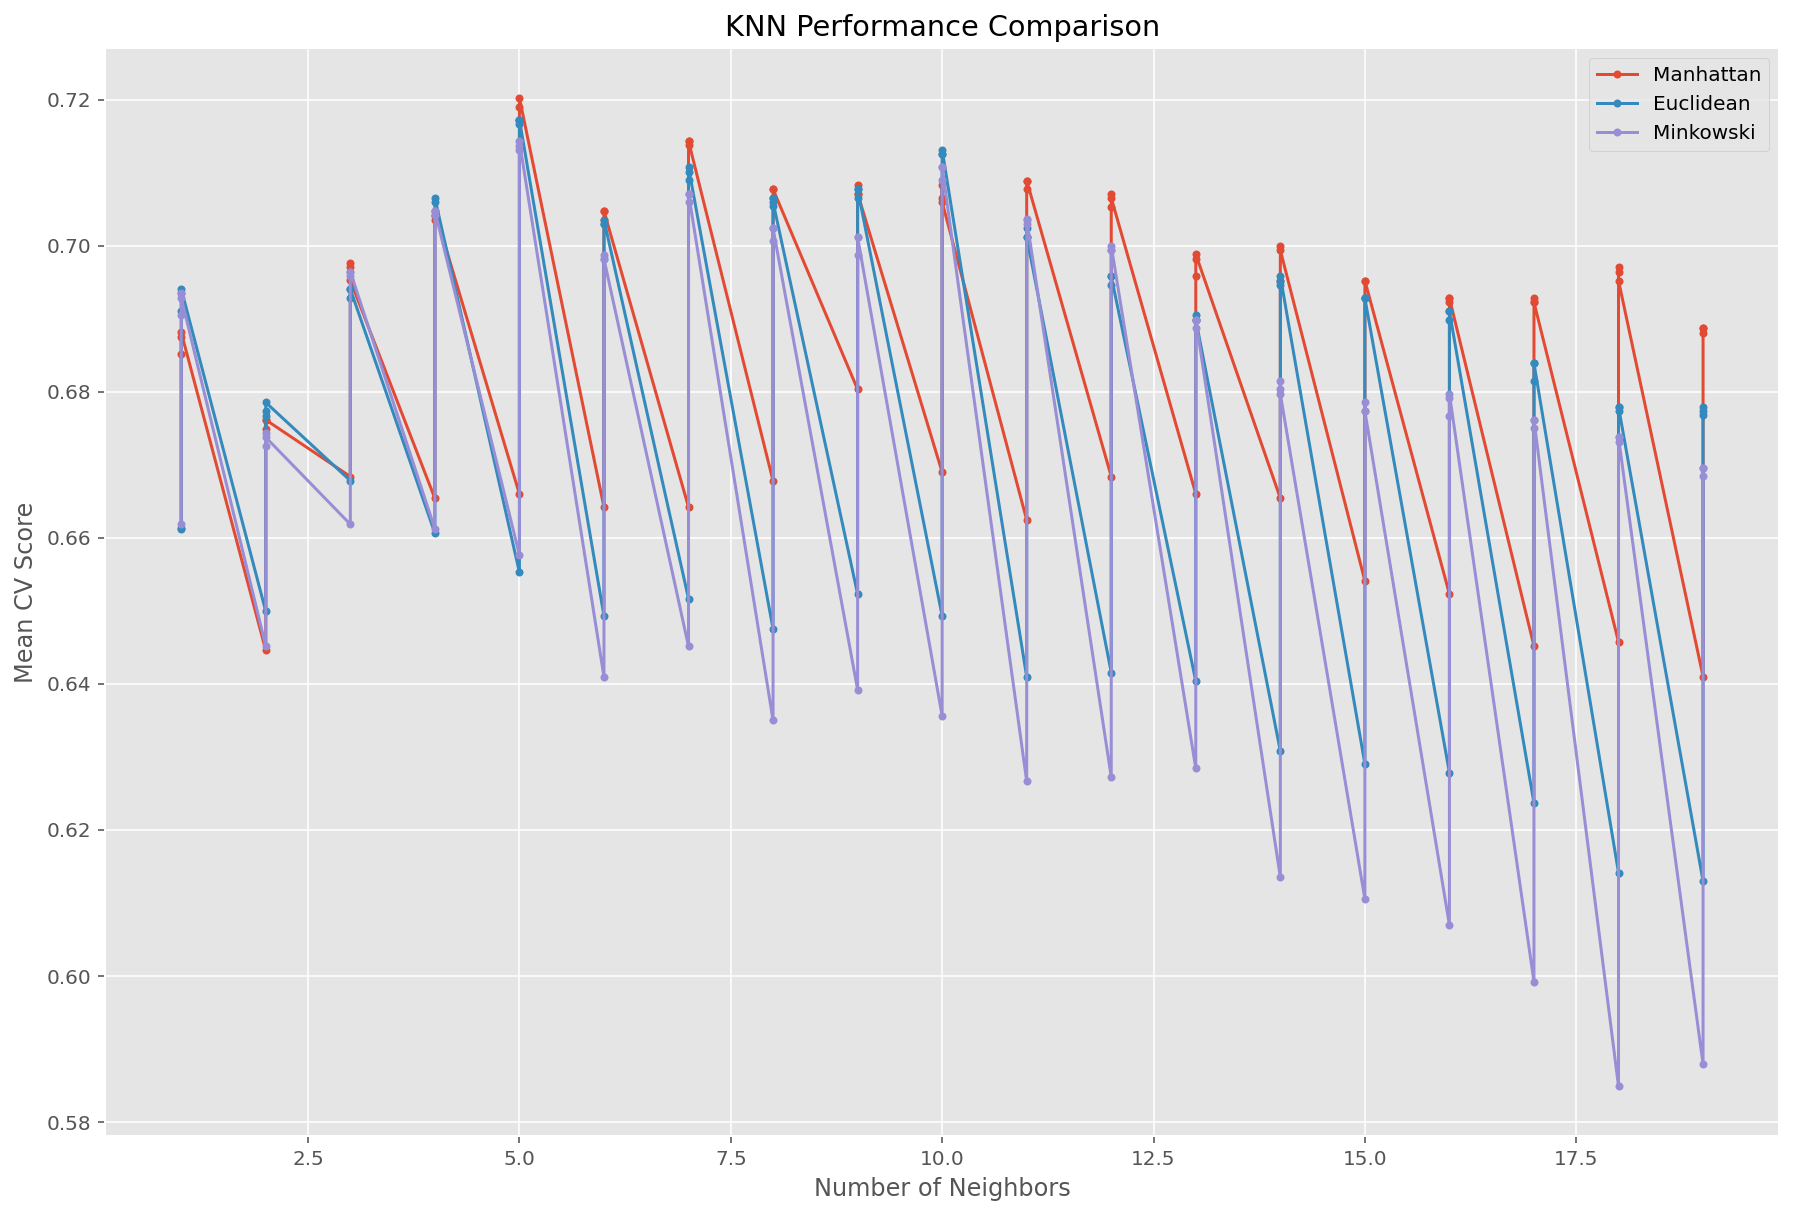

In [62]:

import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = grid_results[grid_results['metric'] == i]
    plt.plot(temp['knn__n_neighbors'], temp['test_score'], marker = '.', label = i)
    
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel("Mean CV Score")
plt.title("KNN Performance Comparison")
plt.show()